In [2]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from statsmodels import stats as sms
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
import re 
import category_encoders as ce
import statsmodels.stats as st
import scipy.stats as stats
from geopy.distance import geodesic
import geopy
from geopy import distance
from sklearn.feature_selection import chi2 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
nltk.download('vader_lexicon')

/opt/conda/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/opt/conda/lib/python3.10/site-packages/visions/backends/shared/nan_handling.py:51: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def hasna(x: np.ndarray) -> bool:


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


True

# 1. Upload date

In [3]:
original_data = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv')
original_hotel_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv')
hotel_test = original_hotel_test.copy()
data = original_data.copy()

data['sample'] = 0
hotel_test['sample'] = 1



data = pd.concat([data, hotel_test], sort = False, ignore_index = True, axis = 0)

data.fillna(value=0, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

# 2. Data processing

**Take the country information from the address of the hotel address feature and cast the date to a normal type**

In [4]:
data['country'] = data['hotel_address'].str.split()

data['country'] = data['country'].apply(lambda x: str(x[-1]))
data['country'] = data.country.apply(lambda x: 'UK' if x == 'Kingdom' else x)
data['review_date'] = pd.to_datetime(data['review_date'], dayfirst=False)



**We also take data on cities - the output shows that the number of cities is small, which will help us when coding this feature**

In [5]:
data['city'] = data['hotel_address'].apply(lambda x: str(x).split()[-5:])


def city(val):
    val = list(val)
    if 'Kingdom' in val:
        val = val[0]
    else:
        val=val[-2]
    return val
data['city'] = data['city'].apply(city)

data['city'].value_counts()



London       262301
Barcelona     60149
Paris         59928
Amsterdam     57214
Vienna        38939
Milan         37207
Name: city, dtype: int64

**Let's translate the data on longitude and latitude into a common attribute for further calculation of the distance of the hotel to the city center in which it is located**

In [6]:
data['coordinates'] = data.apply(lambda row: (row['lat'], row['lng']) , axis=1) 


**Let's create a dictionary with keys in the form of cities and values in the form of coordinates of the center of the corresponding city**

In [7]:
dict_center_cities = {'Barcelona':(41.3874, 2.1686,),
                      'London':(51.5072, 0.1276),
                      'Paris': (48.8566, 2.3522),
                      'Amsterdam':(52.3676, 4.9041),
                      'Vienna':(48.2082, 16.3738),
                      'Milan': (45.4642, 9.1900)}
dict_center_points = {city: geopy.Point(coord) for city, coord in dict_center_cities.items()}



**Calculate the distance from the hotel to the city center**

In [8]:
data['distance_center'] = data.apply(lambda row: distance.distance(row['coordinates'], dict_center_cities.get(row['city'])).km, axis=1)


**Fill zero values with the median**

In [9]:
data['distance_center'] = data.distance_center.round()


# All that set on the top is ex-nan-values: to ways solve this problem

# 1 Solution
data.loc[data['distance_center'] > 60, 'distance_center'] = data['distance_center'].median()


# 2 Solution
#index = data[data['distance_center'] > 60].index
#data.drop(index=index, inplace=True)



**Get rid of lines that we won't use anymore**

In [10]:
data.drop(columns=['hotel_address', 'coordinates', 'lat', 'lng'], inplace=True)

**Let's look at all possible nationalities of reviewers and leave only those whose share is more than one percent**

In [11]:
dict_countries =  data['reviewer_nationality'].value_counts(normalize=True).nlargest(15)


dict_countries = dict(dict_countries)


data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: str(x) if x in dict_countries.keys() else 'Other')


**Take and tag all possible information. Due to the fact that the tags do not have a single format, we will translate them into strings, and then apply various functions to extract the data**

In [12]:
data_1 = data.copy()

data_1['tags'] = data_1['tags'].apply(eval)

def count_(val):
    for i in val:
        if i in [' Couple ', ' Solo traveler ', ' Group ', ' Family with young children ', ' Family with older children ', ' Travelers with friends ']:
            return i
    return 0

def room(val):
    for i in val:
        if 'room' in str(i).lower():
            return i
    return 0

def stayed(val):
    for i in val:
        if 'stayed' in str(i).lower():
            end = int(i.split()[1])
            return end
    return 0

def submit(val):
    for i in val:
        if 'submitted' in str(i).lower():
            return 1
    return 0 



data_1['tags_duration_in_days'] = data_1['tags'].apply(stayed)
data_1['tags_submitted_from_phone'] = data_1['tags'].apply(submit)
data_1['tags_trip_type'] = data_1['tags'].apply(lambda x: x[0] if 'trip' in x[0] else 0)
data_1['tags_count_of_guests'] = data_1['tags'].apply(count_)
data_1['tags_room'] = data_1['tags'].apply(room)


data_1['tags_room'].nunique() # 1682
# We cannot encode so big amount of feature's types or it is not useful for amount of data features
data = data_1.copy()



**Let's take information about the month from the review date and form a feature about the review season**

In [13]:

data['review_month'] = data['review_date'].dt.month

data['review_month'].value_counts(normalize=True) *100
data['season'] = data['review_month'].map({1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring',
                                    5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
                                    9: 'Autumn', 10: 'Autumn', 11: 'Autumn', 12: 'Winter'})

data.drop(columns=[],inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 25 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   additional_number_of_scoring                515738 non-null  int64         
 1   review_date                                 515738 non-null  datetime64[ns]
 2   average_score                               515738 non-null  float64       
 3   hotel_name                                  515738 non-null  object        
 4   reviewer_nationality                        515738 non-null  object        
 5   negative_review                             515738 non-null  object        
 6   review_total_negative_word_counts           515738 non-null  int64         
 7   total_number_of_reviews                     515738 non-null  int64         
 8   positive_review                             515738 non-null  object       

**Translate the feature about days since review into an integer type**

In [14]:
data['days_since_review'] = data['days_since_review'].apply(lambda x: int(str(x).split()[0]))

**Encode all features that cannot be passed to the model**

In [15]:
encoder = ce.OneHotEncoder(cols=['city', 'country', 'reviewer_nationality', 'tags_submitted_from_phone', 'tags_trip_type', 'tags_count_of_guests','season'], use_cat_names=True)

data = pd.concat([data, encoder.fit_transform(data[['city', 'country', 'reviewer_nationality', 'tags_submitted_from_phone', 'tags_trip_type', 'tags_count_of_guests','season']])], axis=1)

**Let's get rid of all unnecessary features**

In [16]:

data.drop(columns=['tags', 'city', 'country',
                    'reviewer_nationality',
                    'tags_submitted_from_phone',
                    'tags_trip_type', 
                    'tags_count_of_guests', 
                    'tags_room', 'review_date', 
                    'review_month','hotel_name',
                    'season'], 
                    inplace=True)


**We extract data from reviews about their emotional evaluation and leave a common feature**

In [17]:
sia = SentimentIntensityAnalyzer()

data['positive_compound_2'] = data['positive_review'].apply(lambda x: sia.polarity_scores(str(x)).get('compound'))

data['negative_compound_2'] = data['negative_review'].apply(lambda x: sia.polarity_scores(str(x)).get('compound'))


**Let's get rid of all unnecessary features**

In [18]:
data.drop(columns=['positive_review', 'negative_review'], inplace=True)
print(data.columns, len(data.columns))

Index(['additional_number_of_scoring', 'average_score',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score',
       'days_since_review', 'sample', 'distance_center',
       'tags_duration_in_days', 'city_London', 'city_Paris', 'city_Amsterdam',
       'city_Milan', 'city_Vienna', 'city_Barcelona', 'country_UK',
       'country_France', 'country_Netherlands', 'country_Italy',
       'country_Austria', 'country_Spain',
       'reviewer_nationality_ United Kingdom ', 'reviewer_nationality_Other',
       'reviewer_nationality_ France ', 'reviewer_nationality_ Switzerland ',
       'reviewer_nationality_ United Arab Emirates ',
       'reviewer_nationality_ United States of America ',
       'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Italy ',
       'reviewer_nationality_ Ireland ', 'reviewer_nationality_ Canada ',
       'reviewer_nationalit

**Let's make a correlation map to understand which features have multicollinearity and report the same values to the model**

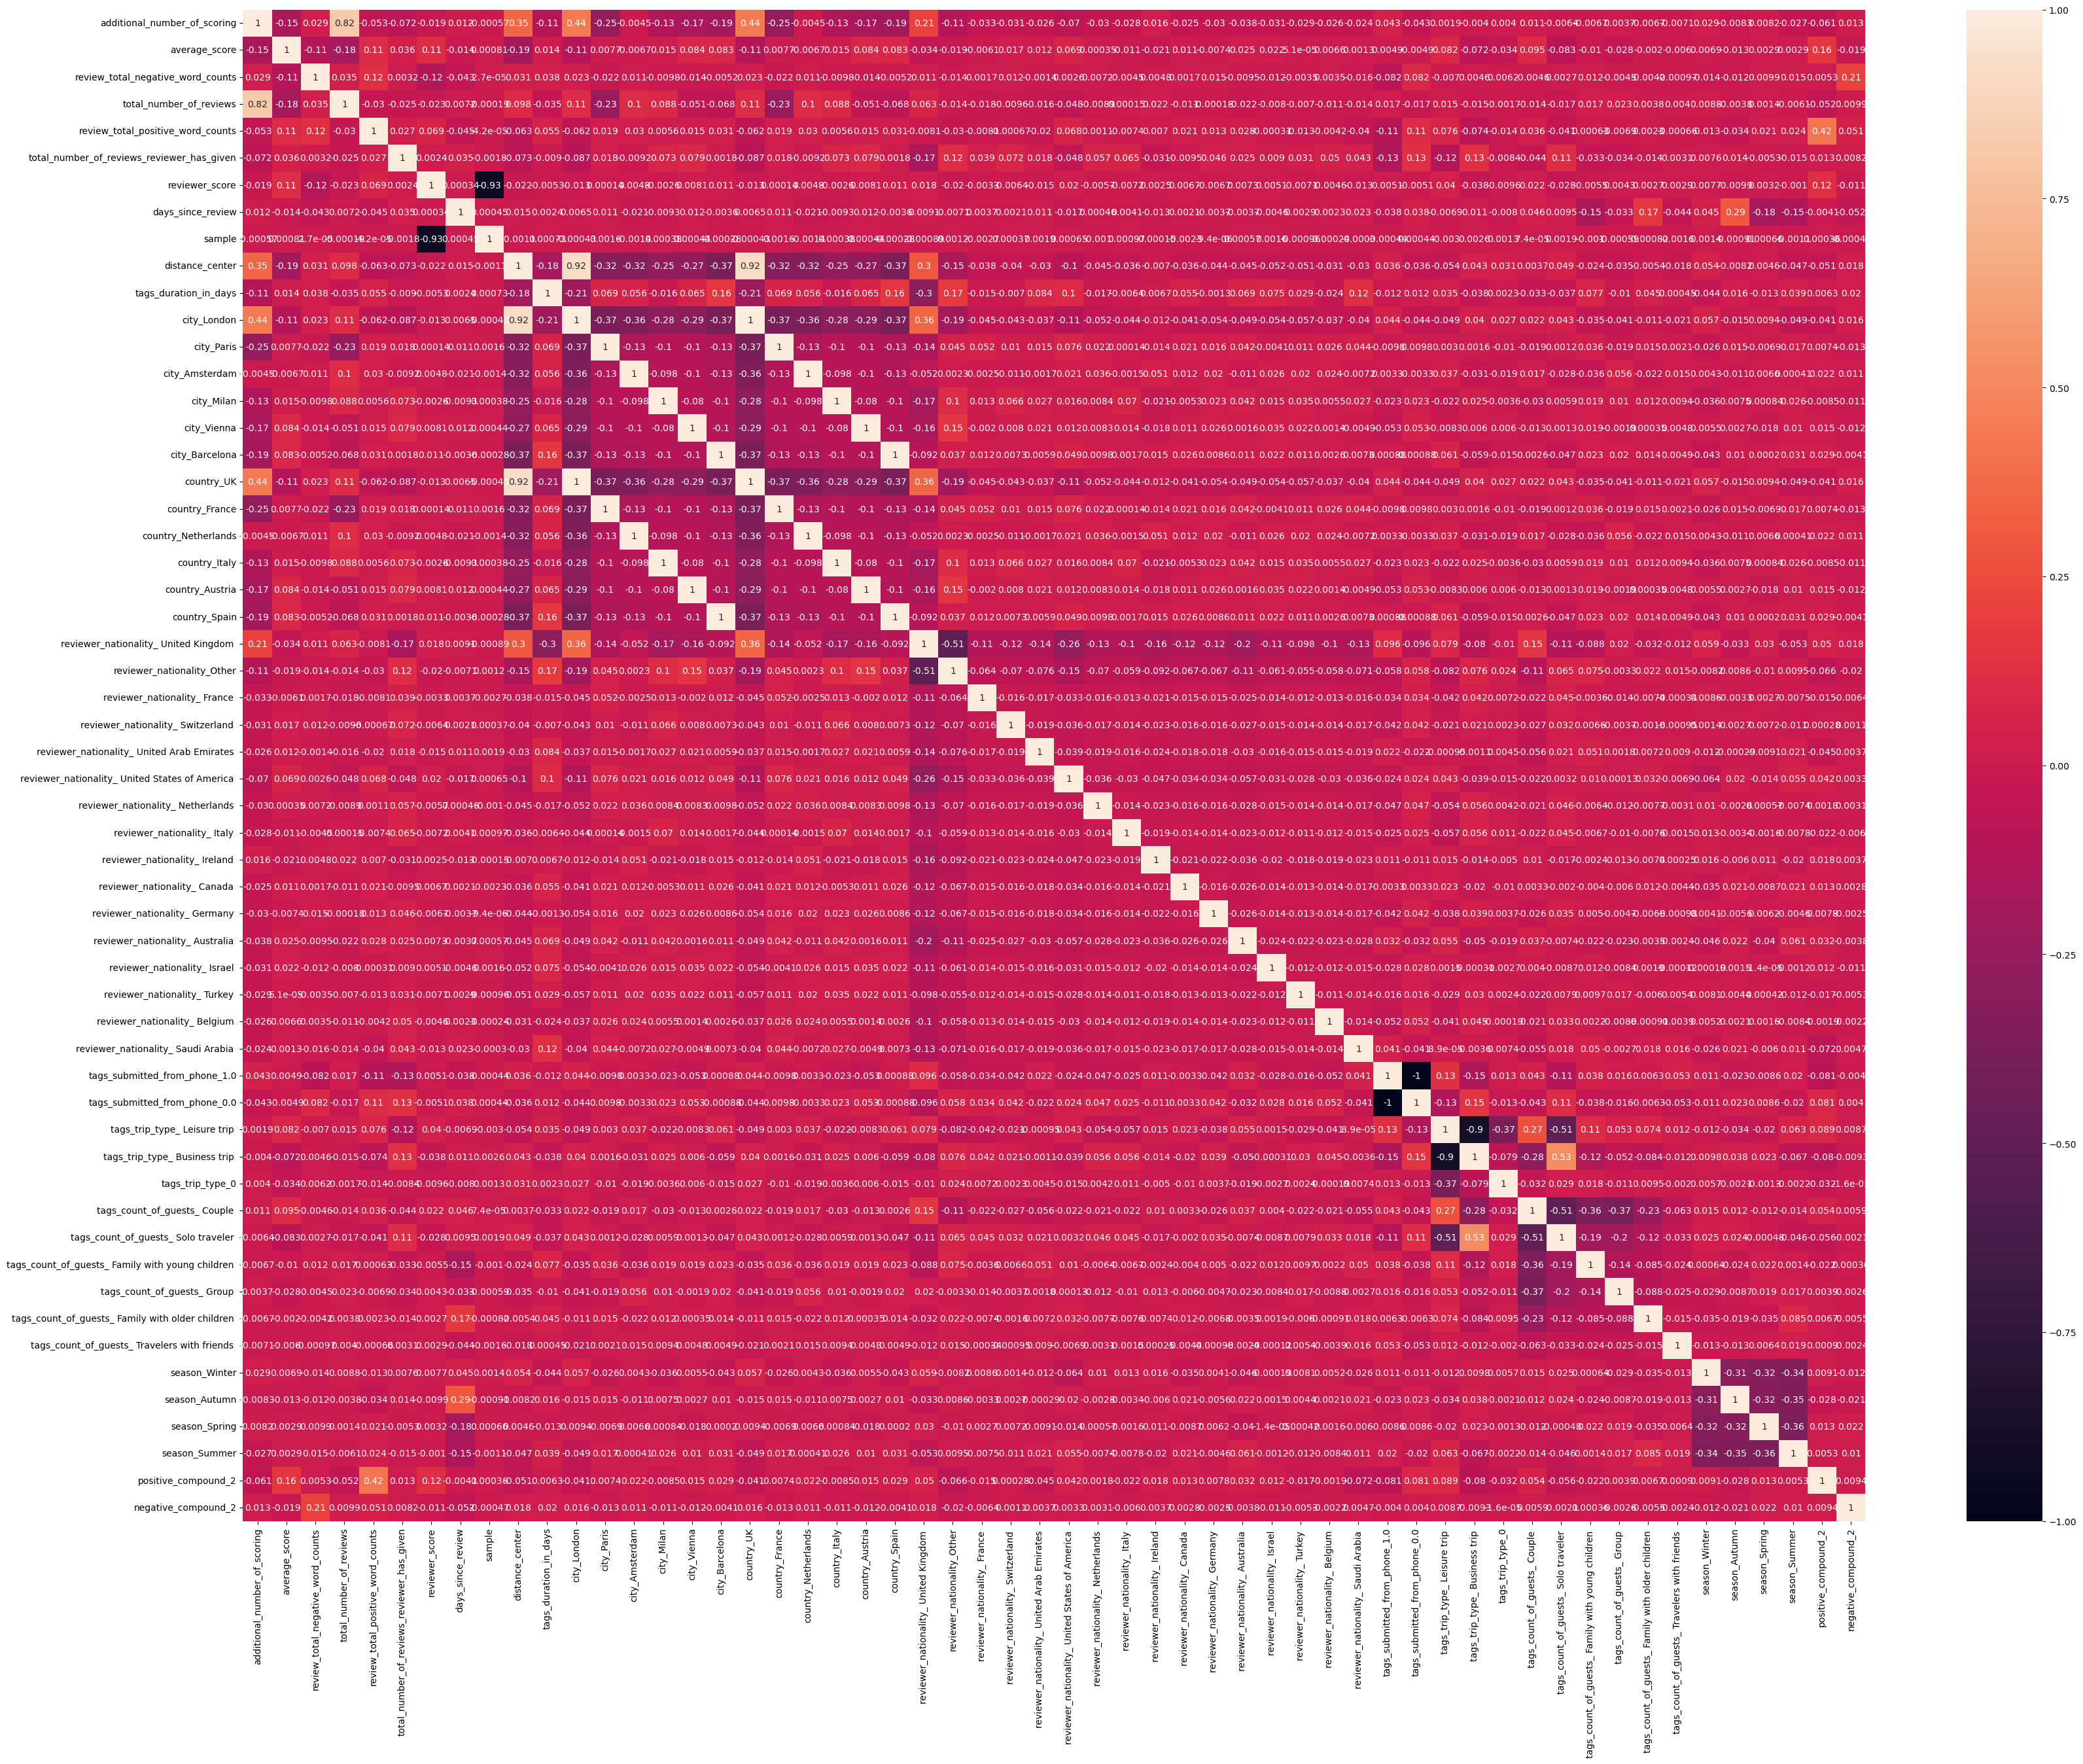

In [19]:

data_corr = data.corr()
fig= plt.subplots(figsize=(40,30))
sns.heatmap(
    data=data_corr,
    annot=True
)
plt.show()

**Removing features with a high correlation coefficient**

In [20]:

data.drop(columns=['tags_submitted_from_phone_0.0',
                    'country_UK', 'country_France', 'country_Netherlands',
                    'country_Italy', 'country_Austria', 'country_Spain',  'days_since_review']
                    , inplace=True)


**Let's divide all features into subgroups of quantitative and qualitative types**

In [21]:


num_cols = ['total_number_of_reviews', 'review_total_negative_word_counts', 'additional_number_of_scoring',
            'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given',
            'tags_duration_in_days', 'positive_compound_2',
            'negative_compound_2', 'distance_center']

cat_cols = ['city_London',
       'city_Paris', 'city_Amsterdam', 'city_Milan', 'city_Vienna',
       'city_Barcelona',
       'reviewer_nationality_ United Kingdom ', 'reviewer_nationality_Other',
       'reviewer_nationality_ France ', 'reviewer_nationality_ Switzerland ',
       'reviewer_nationality_ United Arab Emirates ',
       'reviewer_nationality_ United States of America ',
       'reviewer_nationality_ Netherlands ', 'reviewer_nationality_ Italy ',
       'reviewer_nationality_ Ireland ', 'reviewer_nationality_ Canada ',
       'reviewer_nationality_ Germany ', 'reviewer_nationality_ Australia ',
       'reviewer_nationality_ Israel ', 'reviewer_nationality_ Turkey ',
       'reviewer_nationality_ Belgium ', 'reviewer_nationality_ Saudi Arabia ',
       'tags_submitted_from_phone_1.0', 'tags_trip_type_ Business trip ',
       'tags_trip_type_0', 'tags_count_of_guests_ Couple ',
       'tags_count_of_guests_ Solo traveler ',
       'tags_count_of_guests_ Family with young children ',
       'tags_count_of_guests_ Group ',
       'tags_count_of_guests_ Family with older children ',
       'tags_count_of_guests_ Travelers with friends ',
       'tags_trip_type_ Leisure trip ',
       'season_Winter', 'season_Autumn', 
       'season_Spring', 'season_Summer']

data_backup = data.copy()

In [22]:
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return cleaned

def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return cleaned


#data = data[data['sample'] == 0]

for i in num_cols:
    data[data['sample'] == 0] = outliers_z_score(data=data, feature=i)
    data[data['sample'] == 0] = outliers_iqr_mod(data=data, feature=i)
    

/tmp/ipykernel_32/1521668772.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data['sample'] == 0][['total_number_of_reviews', 'review_total_negative_word_counts',


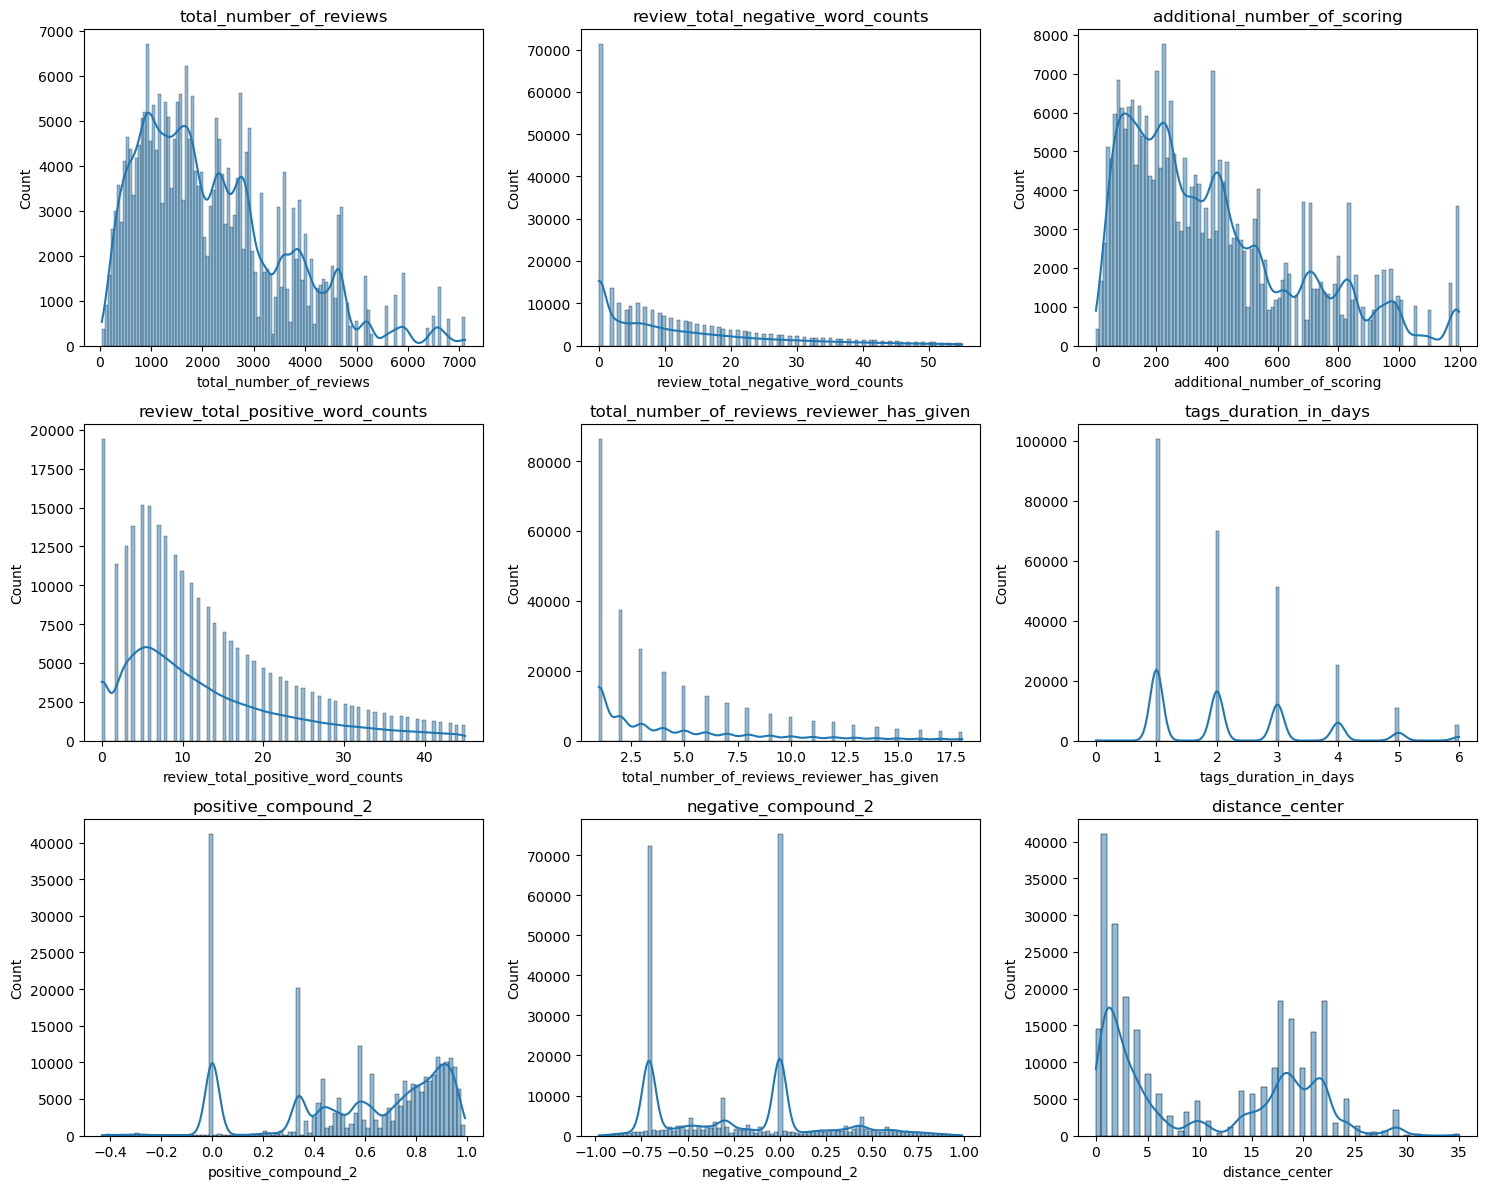

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 48 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   additional_number_of_scoring                       392177 non-null  float64
 1   average_score                                      392177 non-null  float64
 2   review_total_negative_word_counts                  392177 non-null  float64
 3   total_number_of_reviews                            392177 non-null  float64
 4   review_total_positive_word_counts                  392177 non-null  float64
 5   total_number_of_reviews_reviewer_has_given         392177 non-null  float64
 6   reviewer_score                                     392177 non-null  float64
 7   sample                                             392177 non-null  float64
 8   distance_center                                    392177 non-null  float6

In [23]:
from sklearn import preprocessing

data_robut = data[data['sample'] == 0].copy()

robut =  preprocessing.RobustScaler()
data_robut = robut.fit_transform(data_robut[['total_number_of_reviews', 'review_total_negative_word_counts',
                            'additional_number_of_scoring', 'review_total_positive_word_counts',
                            'total_number_of_reviews_reviewer_has_given', 'tags_duration_in_days',
                            'positive_compound_2', 'negative_compound_2', 'distance_center']])
data[data['sample'] == 0][['total_number_of_reviews', 'review_total_negative_word_counts',
                            'additional_number_of_scoring', 'review_total_positive_word_counts',
                            'total_number_of_reviews_reviewer_has_given', 'tags_duration_in_days',
                            'positive_compound_2', 'negative_compound_2', 'distance_center']] = pd.DataFrame(data=data_robut, columns=num_cols)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, column in enumerate(['total_number_of_reviews', 'review_total_negative_word_counts',
                            'additional_number_of_scoring', 'review_total_positive_word_counts',
                            'total_number_of_reviews_reviewer_has_given', 'tags_duration_in_days',
                            'positive_compound_2', 'negative_compound_2', 'distance_center']):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    sns.histplot(data[data['sample'] == 0][column], kde=True, ax=ax)
    ax.set_title(column)

# Устанавливаем промежутки между подграфиками
plt.tight_layout()

# Отображаем графики
plt.show()

data.info()

**We use the f_classif function to determine the significance of each feature and create a graph showing this significance**

In [24]:
data.dropna(inplace=True)

<Axes: >

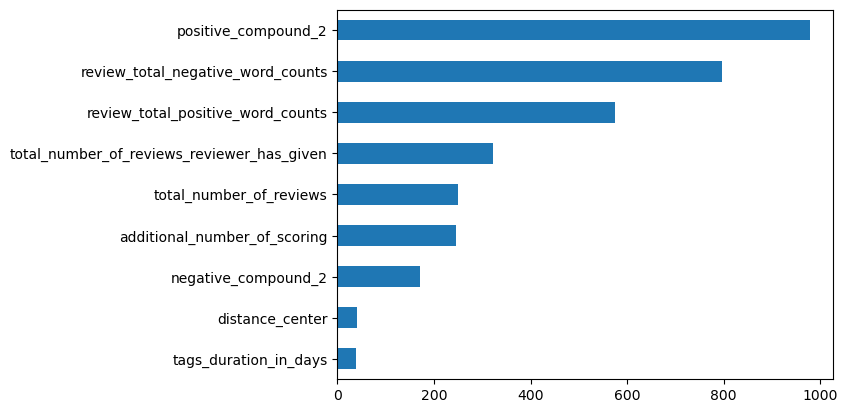

In [25]:
from sklearn.feature_selection import f_classif # anova

  
X = data.drop(['reviewer_score'], axis = 1)  
y = data['reviewer_score']  

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

**Use chi-square to determine the significance of each feature and create a graph showing this significance, but for nominal features**

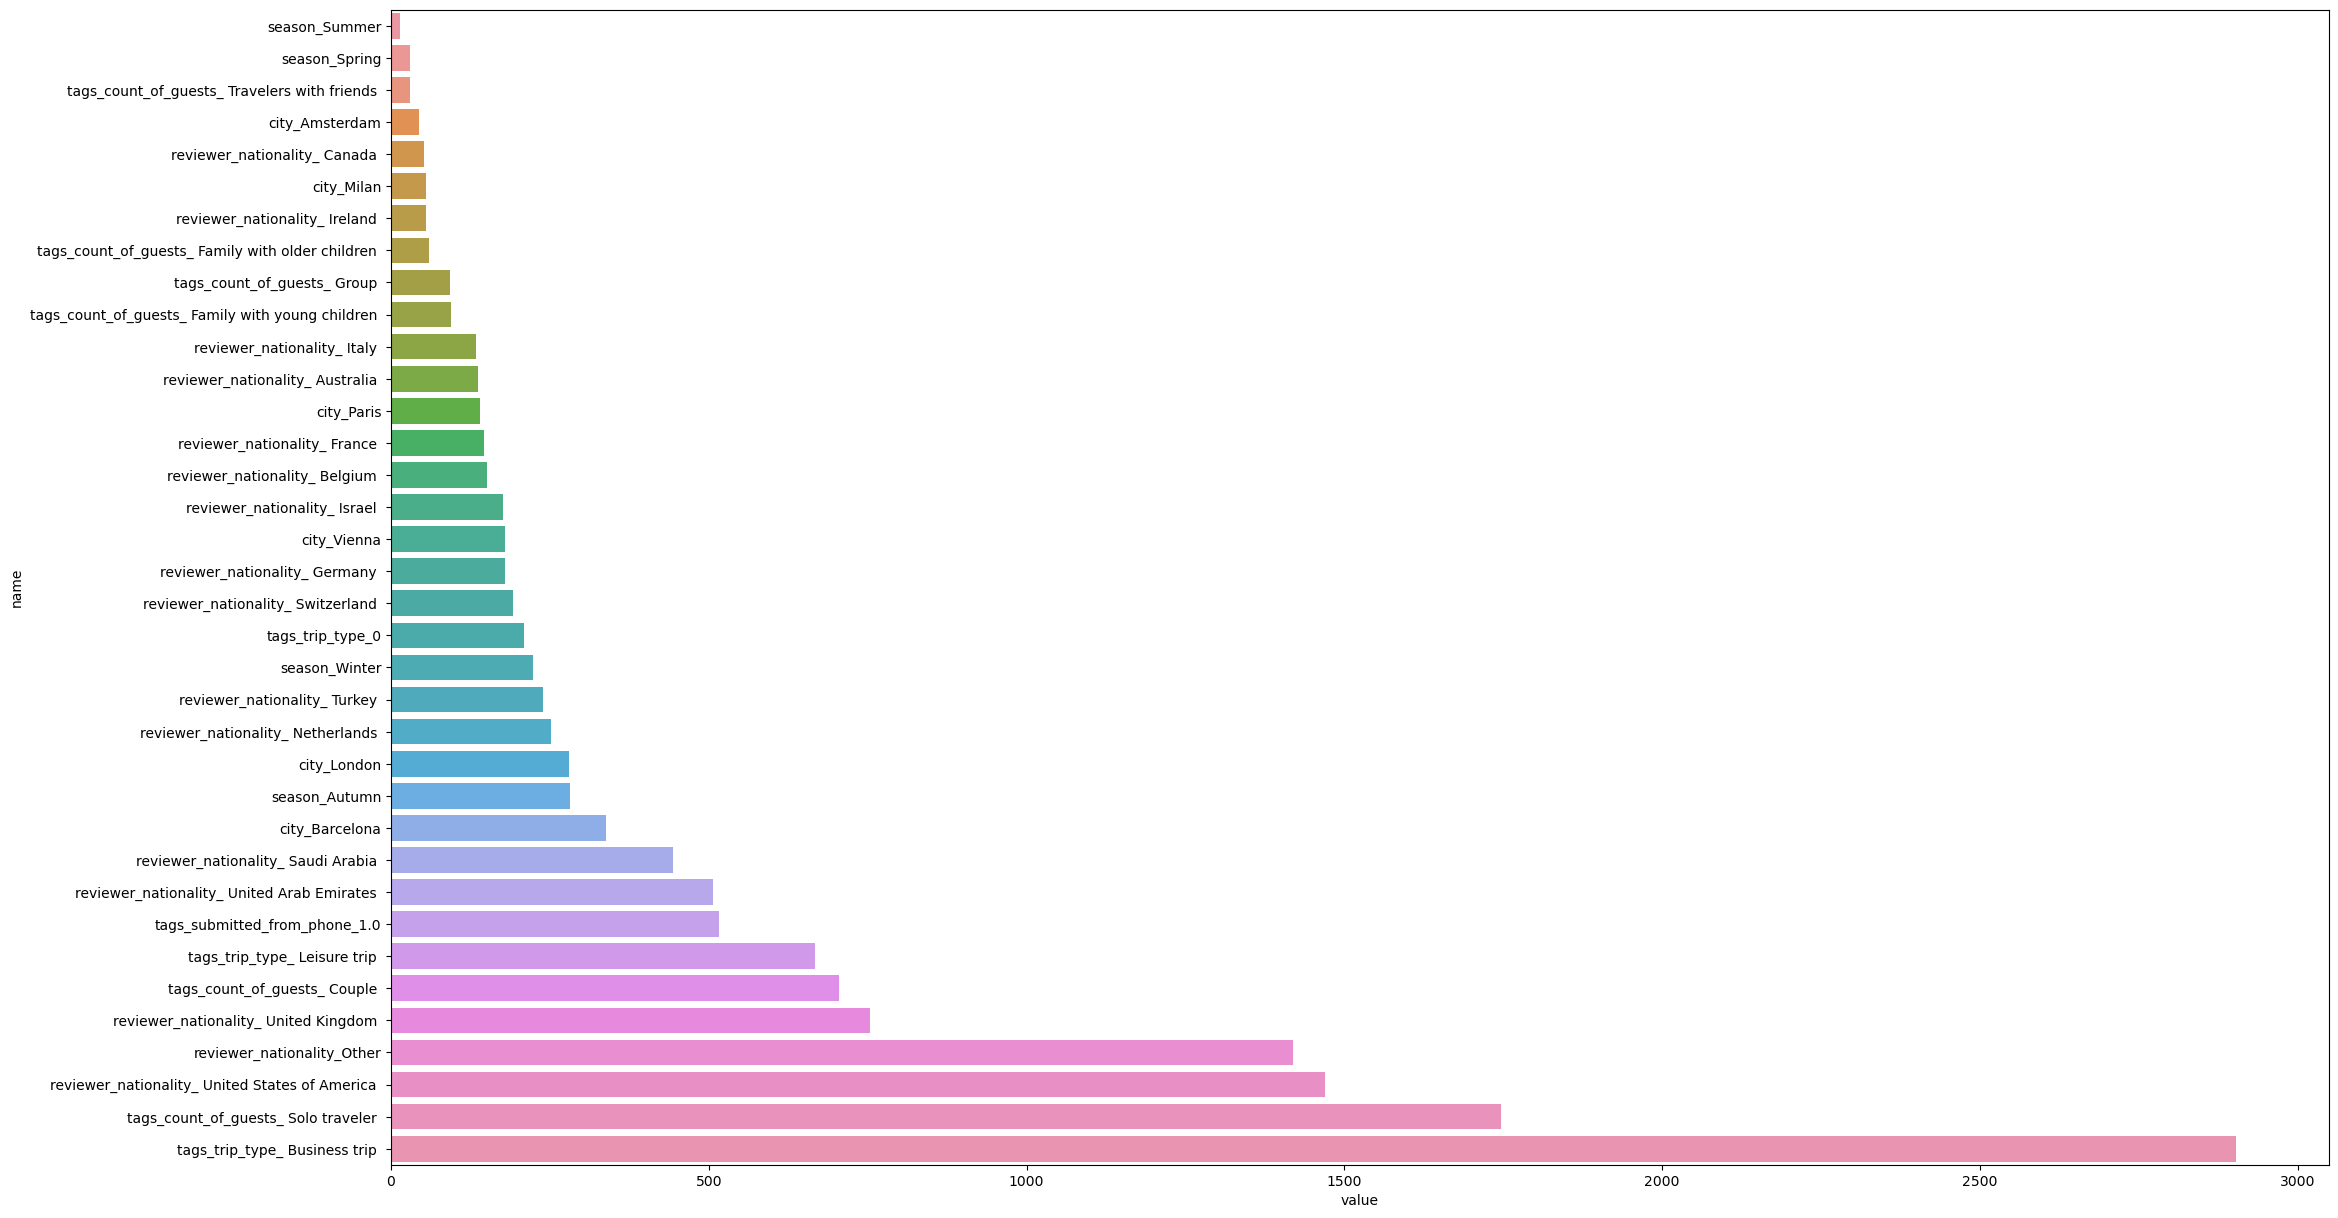

In [26]:


y=y.astype(int)
  
X = data.drop(['reviewer_score'], axis = 1)  


imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)

imp_cat = pd.DataFrame({"value": imp_cat.values, "name": imp_cat.index})



fig, ax = plt.subplots(figsize=(25,15))

sns.barplot(
    data=imp_cat,
    x='value',
    y='name'
)
plt.show()

**We split the data into training and test data and transfer them to new variables**

In [27]:
hotels_train = data[data['sample'] == 0].drop(['sample'], axis=1)
hotels_test = data[data['sample'] == 1].drop(['sample'], axis=1)

X = hotels_train.drop(['reviewer_score'], axis = 1)  
y = hotels_train['reviewer_score']  
      
     
from sklearn.model_selection import train_test_split  
      
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

**We pass the training data to the model and train it**

In [28]:

from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      

regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X, y)  
      
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X)

In [29]:
print('MAPE:', metrics.mean_absolute_percentage_error(y, y_pred)) # 1 MAPE: 0.1250875941786865
                                                                       # 2 MAPE: 0.12545438592636604
                                                                       # 3 MAPE: 0.125221305205904
                                                                       # 4 MAPE: 0.1254208061382068

MAPE: 0.04549525069121893


**Forming a submission file**

In [30]:
submission = pd.read_csv('/kaggle/input/sf-booking/submission.csv')


hotels_test = hotels_test.drop(['reviewer_score'], axis=1)

predict_submission = regr.predict(hotels_test)
submission['reviewer_score'] = predict_submission
submission.to_csv('submission.csv', index=False)
submission.head(5)

,reviewer_score,id
0,8.314,488440
1,7.280,274649
2,8.702,374688
3,9.596,404352
4,9.395,451596
